In [31]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

##### Попробуем подобрать возможную конфигурацию свёрточной сети для задачи классификации рукописных цифр
Для начала загрузим данные

In [44]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

((50000, 1, 28, 28), (50000,))


#### Посмотрим, как выглядят входные данные

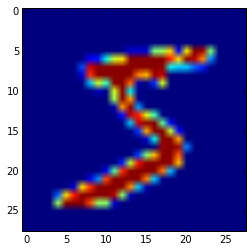

In [34]:
plt.imshow(X_train[0,0])

In [55]:
#вход у нас четырёхмерный, первый параметр задает количество примеров, второй глубину каналов, третий и четвертый - размеры входа
#у нас картинка 28 на 28
input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться"), потом идёт что-то типа глубины канала, у нас картинка чёрно-белая, поэтому
# 1, если бы была цветная, то было бы 3, как в RGB
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

#### Зададим архитектуру сети

In [62]:
# построим для начала свёрточную нейронную сеть
# архитектура нейронной сети стандартная, два свёрточных слоя, после каждого свёрточного идет пулинговый и в конце 
# полносвязный

#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

# сделаем так, чтобы у слоев не было вектора сдвигов b, потому что в нашей модели его нет
conv_1 = lasagne.layers.Conv2DLayer(input_layer, num_filters=8, filter_size=3, name='conv_1', 
                                    nonlinearity=lasagne.nonlinearities.rectify, b=None)

pool_1 = lasagne.layers.Pool2DLayer(conv_1, pool_size=(2,2), name='pool_1', mode='average_inc_pad')

conv_2 = lasagne.layers.Conv2DLayer(pool_1, num_filters=8, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify, 
                                    name='conv_2', b=None)
pool_2 = lasagne.layers.Pool2DLayer(conv_2, pool_size=(2,2), name='pool_2', mode='average_inc_pad')

dense_1 = lasagne.layers.DenseLayer(pool_2, num_units=128, b=None, name='dense_1')

#ВЫХОДНОЙ полносвязный слой, который имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1, num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output', b=None)

In [63]:
#предсказание нейронки (theano-преобразование), это результат применения softmax к выходу предпоследнего слоя
y_predicted = lasagne.layers.get_output(dense_output)

In [64]:
#все веса нейронки (shared-переменные), как раз все параметры, которые будут меняться при обучении
all_weights = lasagne.layers.get_all_params(dense_output)
print (all_weights)

[conv_1.W, conv_2.W, dense_1.W, output.W]


In [65]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
# первый параметр - что мы дифференцируем, потом по чему мы дифференцируем, ну и скорость обучения
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [66]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [67]:
from random import shuffle
import math

# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# X - тензор из картинок размером (много, 1, 28, 28), например - X_train
# y - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
#batch_size - одно число - желаемый размер группы

def iterate_minibatches(X, y, batchsize):
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X[excerpt], y[excerpt]

#### Начинаем учить нашу сеть

In [ ]:
import time
from tqdm import tqdm

num_epochs = 100 #количество проходов по данным

batch_size = 50 #размер мини-батча

train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        
        
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    
    train_accuracy.append(train_acc / train_batches * 100)
    val_accuracy.append(val_acc / val_batches * 100)

  1%|          | 1/100 [00:17<28:53, 17.51s/it]

Epoch 1 of 100 took 17.513s
  training loss (in-iteration):		0.161176
  train accuracy:		94.97 %
  validation accuracy:		97.26 %
Epoch 2 of 100 took 16.617s

  2%|▏         | 2/100 [00:34<28:10, 17.25s/it]


  training loss (in-iteration):		0.062849
  train accuracy:		98.10 %
  validation accuracy:		98.54 %
Epoch 3 of 100 took 18.092s

  3%|▎         | 3/100 [00:52<28:17, 17.50s/it]


  training loss (in-iteration):		0.046772
  train accuracy:		98.63 %
  validation accuracy:		98.40 %
Epoch 4 of 100 took 18.439s

  4%|▍         | 4/100 [01:10<28:27, 17.78s/it]


  training loss (in-iteration):		0.041140
  train accuracy:		98.75 %
  validation accuracy:		98.28 %
Epoch 5 of 100 took 17.280s

  5%|▌         | 5/100 [01:27<27:55, 17.63s/it]


  training loss (in-iteration):		0.036267
  train accuracy:		98.93 %
  validation accuracy:		98.69 %
Epoch 6 of 100 took 18.344s

  6%|▌         | 6/100 [01:46<27:57, 17.85s/it]


  training loss (in-iteration):		0.030425
  train accuracy:		99.11 %
  validation accuracy:		98.67 %
Epoch 7 of 100 took 18.639s

  7%|▋         | 7/100 [02:04<28:01, 18.08s/it]


  training loss (in-iteration):		0.029015
  train accuracy:		99.11 %
  validation accuracy:		98.61 %
Epoch 8 of 100 took 17.269s

  8%|▊         | 8/100 [02:22<27:21, 17.84s/it]


  training loss (in-iteration):		0.025086
  train accuracy:		99.24 %
  validation accuracy:		98.76 %
Epoch 9 of 100 took 18.398s

  9%|▉         | 9/100 [02:40<27:18, 18.01s/it]


  training loss (in-iteration):		0.024440
  train accuracy:		99.29 %
  validation accuracy:		98.44 %
Epoch 10 of 100 took 19.081s

 10%|█         | 10/100 [02:59<27:29, 18.33s/it]


  training loss (in-iteration):		0.022952
  train accuracy:		99.34 %
  validation accuracy:		98.86 %
Epoch 11 of 100 took 17.800s

 11%|█         | 11/100 [03:17<26:57, 18.17s/it]


  training loss (in-iteration):		0.020538
  train accuracy:		99.42 %
  validation accuracy:		98.61 %
Epoch 12 of 100 took 18.348s

 12%|█▏        | 12/100 [03:35<26:43, 18.22s/it]


  training loss (in-iteration):		0.017617
  train accuracy:		99.48 %
  validation accuracy:		98.53 %
Epoch 13 of 100 took 18.431s

 13%|█▎        | 13/100 [03:54<26:30, 18.29s/it]


  training loss (in-iteration):		0.017399
  train accuracy:		99.53 %
  validation accuracy:		98.74 %
Epoch 14 of 100 took 19.725s

 14%|█▍        | 14/100 [04:13<26:49, 18.72s/it]


  training loss (in-iteration):		0.016739
  train accuracy:		99.58 %
  validation accuracy:		98.96 %
Epoch 15 of 100 took 18.375s

 15%|█▌        | 15/100 [04:32<26:22, 18.62s/it]


  training loss (in-iteration):		0.017382
  train accuracy:		99.55 %
  validation accuracy:		98.52 %
Epoch 16 of 100 took 17.540s

 16%|█▌        | 16/100 [04:49<25:36, 18.29s/it]


  training loss (in-iteration):		0.018857
  train accuracy:		99.53 %
  validation accuracy:		98.35 %
Epoch 17 of 100 took 18.222s

 17%|█▋        | 17/100 [05:08<25:16, 18.27s/it]


  training loss (in-iteration):		0.017851
  train accuracy:		99.58 %
  validation accuracy:		98.27 %
Epoch 18 of 100 took 17.750s

 18%|█▊        | 18/100 [05:25<24:45, 18.12s/it]


  training loss (in-iteration):		0.013681
  train accuracy:		99.62 %
  validation accuracy:		98.71 %
Epoch 19 of 100 took 17.972s

 19%|█▉        | 19/100 [05:43<24:23, 18.07s/it]


  training loss (in-iteration):		0.019765
  train accuracy:		99.54 %
  validation accuracy:		98.77 %
Epoch 20 of 100 took 18.742s

 20%|██        | 20/100 [06:02<24:21, 18.27s/it]


  training loss (in-iteration):		0.017746
  train accuracy:		99.58 %
  validation accuracy:		98.56 %
Epoch 21 of 100 took 17.545s

 21%|██        | 21/100 [06:20<23:46, 18.06s/it]


  training loss (in-iteration):		0.015815
  train accuracy:		99.61 %
  validation accuracy:		98.67 %
Epoch 22 of 100 took 18.308s

 22%|██▏       | 22/100 [06:38<23:34, 18.13s/it]


  training loss (in-iteration):		0.016603
  train accuracy:		99.65 %
  validation accuracy:		98.68 %
Epoch 23 of 100 took 16.706s

 23%|██▎       | 23/100 [06:55<22:43, 17.70s/it]


  training loss (in-iteration):		0.015845
  train accuracy:		99.64 %
  validation accuracy:		98.89 %
Epoch 24 of 100 took 16.141s

 24%|██▍       | 24/100 [07:11<21:49, 17.24s/it]


  training loss (in-iteration):		0.013199
  train accuracy:		99.75 %
  validation accuracy:		98.84 %
Epoch 25 of 100 took 17.236s

 25%|██▌       | 25/100 [07:28<21:32, 17.24s/it]


  training loss (in-iteration):		0.016751
  train accuracy:		99.68 %
  validation accuracy:		98.51 %
Epoch 26 of 100 took 18.085s

 26%|██▌       | 26/100 [07:46<21:34, 17.49s/it]


  training loss (in-iteration):		0.014600
  train accuracy:		99.71 %
  validation accuracy:		98.72 %
Epoch 27 of 100 took 17.817s

 27%|██▋       | 27/100 [08:04<21:24, 17.59s/it]


  training loss (in-iteration):		0.013372
  train accuracy:		99.70 %
  validation accuracy:		98.75 %
Epoch 28 of 100 took 16.759s

 28%|██▊       | 28/100 [08:21<20:48, 17.34s/it]


  training loss (in-iteration):		0.012530
  train accuracy:		99.73 %
  validation accuracy:		98.83 %
Epoch 29 of 100 took 17.787s

 29%|██▉       | 29/100 [08:39<20:40, 17.48s/it]

#### Смотрим на результат обучения

In [70]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 80 уровня")
else:
    print ("Нужно больше магии!")

Final results:
  test accuracy:		98.87 %
Нужно больше магии!


In [71]:
# теперь попробуем вывести все веса нашей сети
print("params: ", lasagne.layers.get_all_param_values(dense_output))

('params: ', [array([[[[-0.38140815,  0.23089301, -0.39452899],
         [-0.04699247,  1.00337606,  0.37123418],
         [-1.19439398,  0.58000782, -0.03730586]]],


       [[[-0.76883331, -2.07941229,  0.58086353],
         [ 1.32800194,  0.22003079, -2.2914657 ],
         [ 0.56892227,  0.19438745, -0.55744083]]],


       [[[ 0.32591843,  1.20898182, -0.13737764],
         [-0.27222527,  0.9476178 , -0.34274169],
         [-0.77002458, -1.61394724,  0.28500323]]],


       [[[-0.16291594, -0.00462083, -0.48460007],
         [-0.27254397, -0.194084  , -0.04858539],
         [-0.2737974 , -0.01765121, -0.05429959]]],


       [[[-0.20917413, -0.95642987, -1.54939221],
         [-0.65577682, -0.05296754,  0.60839846],
         [ 0.92404556, -0.02890448,  0.61255636]]],


       [[[-0.92435701, -0.95288873, -0.56835973],
         [-0.04326732,  1.64382631,  0.82483087],
         [ 0.5600978 , -1.48340141, -0.78972855]]],


       [[[ 0.07537838, -0.40051056, -0.15468387],
         [ 1

In [72]:
#сохраняем всё в файлик
np.savez('cnn_weights.npz', *lasagne.layers.get_all_param_values(dense_output))

In [73]:
#так можно установить веса
with np.load('cnn_weights.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(dense_output, param_values)